In [1]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import CMR_IA as cmr
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16

In [2]:
with open("simu4_data/simu4_design.pkl", 'rb') as inp:
    df_study = pickle.load(inp)
    df_test = pickle.load(inp)

In [3]:
# df_study = df_study.loc[df_study.session < 100]
df_study

,itemno,item,itemno_old,freq,quantile,session
0,316,FARM,552,1161,8,0
1,477,LEOPARD,812,118,3,0
2,433,INSTRUCTOR,741,78,2,0
3,87,BOTTLE,153,1479,8,0
4,84,BOOT,150,149,3,0
...,...,...,...,...,...,...
99995,895,TOWN,1491,3328,9,999
99996,633,PIANO,1057,466,6,999
99997,843,SUBMARINE,1398,154,3,999
99998,462,LABYRINTH,791,32,0,999


In [4]:
# df_test = df_test.loc[df_test.session < 100]
df_test

,itemno,item,itemno_old,freq,quantile,session,old
0,341,FORT,595,411,6,0,True
1,512,MANSION,864,156,3,0,True
2,66,BENCH,121,345,6,0,True
3,386,GUARD,667,658,7,0,False
4,57,BEE,112,185,4,0,True
...,...,...,...,...,...,...,...
199995,503,LUNG,850,169,4,999,True
199996,891,TORNADO,1485,34,0,999,False
199997,932,VEHICLE,1553,383,6,999,False
199998,735,RUG,1215,321,5,999,True


### Run CMR-IA

In [5]:
s_mat = np.load('simu4_data/simu4_smat.npy')
# s_mat = np.load('../Data/simu4_smat_lsa.npy')

In [6]:
params = cmr.make_default_params()
params.update(
    beta_enc = 0.55,
    beta_cue = 0.1,
    beta_distract = 0.2,
    gamma_fc = 0.1,
    s_fc = 0.1,
    c_thresh_itm = -0.038,
    m = 20,
    n = -1.35,
    c1 = 2.2,
)
params

{'beta_enc': 0.55,
 'beta_rec': 0.5,
 'beta_cue': 0.1,
 'beta_rec_post': 0.5,
 'beta_distract': 0.2,
 'phi_s': 2,
 'phi_d': 0.5,
 's_cf': 0,
 's_fc': 0.1,
 'kappa': 0.5,
 'eta': 0.5,
 'omega': 5,
 'alpha': 1,
 'c_thresh': 0.5,
 'c_thresh_itm': -0.038,
 'c_thresh_ass': 0.5,
 'd_ass': 1,
 'lamb': 0.5,
 'rec_time_limit': 60000.0,
 'dt': 10,
 'nitems_in_accumulator': 50,
 'max_recalls': 50,
 'learn_while_retrieving': False,
 'a': 2800,
 'b': 20,
 'm': 20,
 'n': -1.35,
 'c1': 2.2,
 'thresh_sigma': 0,
 'No_recall': None,
 'var_enc': 1,
 'bad_enc_ratio': 1,
 'gamma_fc': 0.1,
 'gamma_cf': 0.5}

In [7]:
df_simu = cmr.run_norm_recog_multi_sess(params,df_study,df_test,s_mat)
df_simu

CMR Time: 86.14990401268005


,session,itemno,s_resp,s_rt,csim
0,0,341,0.0,105.774239,0.125803
1,0,512,1.0,17.476126,0.215827
2,0,66,0.0,261.678955,0.080513
3,0,386,0.0,364.351685,0.063963
4,0,57,0.0,19.403059,0.210597
...,...,...,...,...,...
199995,999,503,1.0,19.318922,0.210814
199996,999,891,0.0,71.083321,0.145676
199997,999,932,1.0,19.233486,0.211036
199998,999,735,1.0,3.647263,0.294170


In [8]:
df_simu = df_simu.merge(df_test,on=['session','itemno'])
df_simu

,session,itemno,s_resp,s_rt,csim,item,itemno_old,freq,quantile,old
0,0,341,0.0,105.774239,0.125803,FORT,595,411,6,True
1,0,512,1.0,17.476126,0.215827,MANSION,864,156,3,True
2,0,66,0.0,261.678955,0.080513,BENCH,121,345,6,True
3,0,386,0.0,364.351685,0.063963,GUARD,667,658,7,False
4,0,57,0.0,19.403059,0.210597,BEE,112,185,4,True
...,...,...,...,...,...,...,...,...,...,...
199995,999,503,1.0,19.318922,0.210814,LUNG,850,169,4,True
199996,999,891,0.0,71.083321,0.145676,TORNADO,1485,34,0,False
199997,999,932,1.0,19.233486,0.211036,VEHICLE,1553,383,6,False
199998,999,735,1.0,3.647263,0.294170,RUG,1215,321,5,True


In [9]:
df_simu.groupby(['old']).s_resp.mean()

old
False    0.14788
True     0.82028
Name: s_resp, dtype: float64

### WFE

In [10]:
# get wordfreq quantile
with open('simu4_data/simu4_word_freq.pkl', 'rb') as inp:
    df = pickle.load(inp)
df

,item,itemno_old,itemno,freq,quantile
0,ABDOMEN,1,1,110,2
1,ACROBAT,4,2,17,0
2,ADULT,8,3,906,8
3,ALLEY,15,4,165,3
4,ALLIGATOR,16,5,12,0
...,...,...,...,...,...
979,YOKE,1632,980,12,0
980,YOLK,1633,981,47,1
981,YOUTH,1634,982,1159,8
982,ZIPPER,1636,983,24,0


In [11]:
freq_mean = df.groupby("quantile").freq.mean().to_numpy()
freq_mean = np.around(freq_mean, decimals=0)
freq_mean

array([  22.,   54.,   92.,  143.,  200.,  286.,  417.,  635., 1159.,
       4332.])

In [12]:
s_mean = np.mean(s_mat,axis=1)
c_vec_cal = params['c1'] * s_mean + params['c_thresh']
df['c_vec'] = c_vec_cal
df.groupby("quantile").c_vec.mean()

quantile
0    0.757742
1    0.764246
2    0.751386
3    0.743305
4    0.746196
5    0.736574
6    0.733167
7    0.725391
8    0.714897
9    0.715112
Name: c_vec, dtype: float64

In [13]:
item2q = df[["itemno","quantile"]].set_index("itemno").to_dict()['quantile']
create_level = {0:"new lf", 1:"new hf", 2:"old lf", 3:"old hf"}

df_simu['quantile'] = df_simu.apply(lambda x: item2q[x["itemno"]], axis=1)
df_simu['hf'] = df_simu['quantile'] >= 5
df_simu['level'] = df_simu.apply(lambda x: create_level[x['old'] * 2 + x['hf']], axis = 1)
df_simu

,session,itemno,s_resp,s_rt,csim,item,itemno_old,freq,quantile,old,hf,level
0,0,341,0.0,105.774239,0.125803,FORT,595,411,6,True,True,old hf
1,0,512,1.0,17.476126,0.215827,MANSION,864,156,3,True,False,old lf
2,0,66,0.0,261.678955,0.080513,BENCH,121,345,6,True,True,old hf
3,0,386,0.0,364.351685,0.063963,GUARD,667,658,7,False,True,new hf
4,0,57,0.0,19.403059,0.210597,BEE,112,185,4,True,False,old lf
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,999,503,1.0,19.318922,0.210814,LUNG,850,169,4,True,False,old lf
199996,999,891,0.0,71.083321,0.145676,TORNADO,1485,34,0,False,False,new lf
199997,999,932,1.0,19.233486,0.211036,VEHICLE,1553,383,6,False,True,new hf
199998,999,735,1.0,3.647263,0.294170,RUG,1215,321,5,True,True,old hf


In [14]:
# shifting decision criterion by word freq
b0 = 0.28
b1 = -0.01
df_simu['mean_freq'] = df_simu.apply(lambda x:freq_mean[x['quantile']], axis=1)
df_simu['criterion'] = df_simu.apply(lambda x:b0 + b1*np.log(x['mean_freq']), axis=1)
# df_simu['s_resp'] = df_simu.apply(lambda x:1 if x['csim'] >= x['criterion'] else 0, axis=1)
df_simu

,session,itemno,s_resp,s_rt,csim,item,itemno_old,freq,quantile,old,hf,level,mean_freq,criterion
0,0,341,0.0,105.774239,0.125803,FORT,595,411,6,True,True,old hf,417.0,0.219669
1,0,512,1.0,17.476126,0.215827,MANSION,864,156,3,True,False,old lf,143.0,0.230372
2,0,66,0.0,261.678955,0.080513,BENCH,121,345,6,True,True,old hf,417.0,0.219669
3,0,386,0.0,364.351685,0.063963,GUARD,667,658,7,False,True,new hf,635.0,0.215464
4,0,57,0.0,19.403059,0.210597,BEE,112,185,4,True,False,old lf,200.0,0.227017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,999,503,1.0,19.318922,0.210814,LUNG,850,169,4,True,False,old lf,200.0,0.227017
199996,999,891,0.0,71.083321,0.145676,TORNADO,1485,34,0,False,False,new lf,22.0,0.249090
199997,999,932,1.0,19.233486,0.211036,VEHICLE,1553,383,6,False,True,new hf,417.0,0.219669
199998,999,735,1.0,3.647263,0.294170,RUG,1215,321,5,True,True,old hf,286.0,0.223440


In [15]:
df_tmp = df_simu.groupby(["old","quantile"]).csim.mean().to_frame().reset_index()
df_tmp = pd.pivot_table(data=df_tmp,values='csim',columns='old',index='quantile').reset_index()
df_tmp['True-False'] = df_tmp[True] - df_tmp[False]
df_tmp['c_vec'] = df.groupby("quantile").c_vec.mean()
df_tmp

old,quantile,False,True,True-False,c_vec
0,0,0.193208,0.245722,0.052514,0.757742
1,1,0.197305,0.251790,0.054485,0.764246
2,2,0.187606,0.237605,0.049999,0.751386
3,3,0.180367,0.229695,0.049328,0.743305
4,4,0.183331,0.231303,0.047972,0.746196
5,5,0.174731,0.221033,0.046302,0.736574
6,6,0.172734,0.216592,0.043858,0.733167
7,7,0.166420,0.210126,0.043706,0.725391
8,8,0.157893,0.197579,0.039686,0.714897
9,9,0.155955,0.196027,0.040072,0.715112


In [16]:
df_itemgp = pd.pivot_table(df_simu, values='s_resp', index=['itemno'],
                    columns=['old'],aggfunc = np.mean)
df_itemgp.columns = ['far','hr']
df_itemgp = df_itemgp.reset_index()
# df_itemgp

In [17]:
df_itemgp = df_itemgp.merge(df,on=['itemno'])
df_itemgp

,itemno,far,hr,item,itemno_old,freq,quantile,c_vec
0,1,0.043956,0.865169,ABDOMEN,1,110,2,0.767518
1,2,0.500000,0.851064,ACROBAT,4,17,0,0.673160
2,3,0.206522,0.800000,ADULT,8,906,8,0.699561
3,4,0.009009,0.823529,ALLEY,15,165,3,0.756022
4,5,0.009709,0.873016,ALLIGATOR,16,12,0,0.827650
...,...,...,...,...,...,...,...,...
979,980,0.160377,0.850467,YOKE,1632,12,0,0.731219
980,981,0.009434,0.892157,YOLK,1633,47,1,0.809110
981,982,0.372549,0.670103,YOUTH,1634,1159,8,0.653168
982,983,0.000000,0.842593,ZIPPER,1636,24,0,0.791994


In [18]:
df_quantgp = df_itemgp.groupby(['quantile']).agg({'hr': 'mean', 'far': 'mean'}).reset_index()
df_quantgp['freq_mean'] = freq_mean
df_quantgp

,quantile,hr,far,freq_mean
0,0,0.838084,0.104253,22.0
1,1,0.822008,0.117281,54.0
2,2,0.825868,0.127067,92.0
3,3,0.826916,0.118344,143.0
4,4,0.830016,0.132328,200.0
5,5,0.821287,0.154777,286.0
6,6,0.808039,0.151980,417.0
7,7,0.824134,0.172320,635.0
8,8,0.806258,0.215908,1159.0
9,9,0.798805,0.183219,4332.0


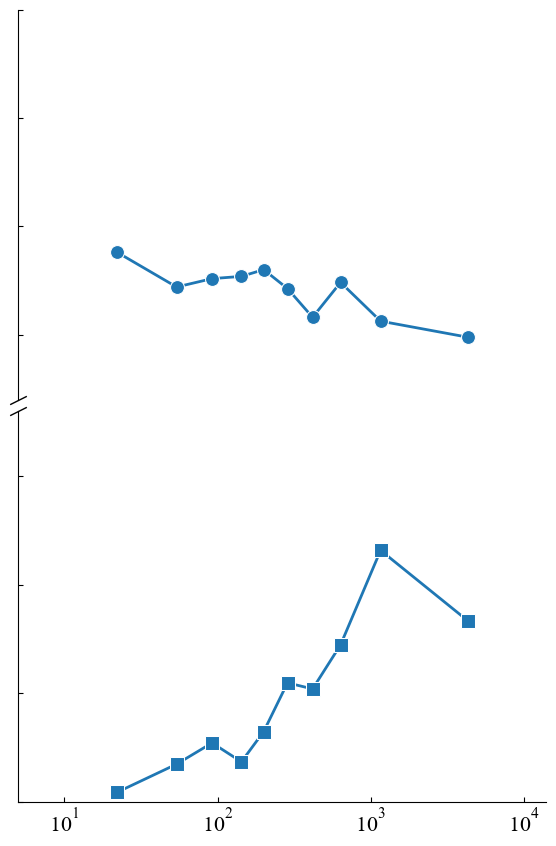

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(6,9))
fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)
fig.subplots_adjust(hspace=0.03)

sns.lineplot(data=df_quantgp, y='hr', x='freq_mean', ax=ax1, marker = 'o', color = 'C0', markersize = 10, linewidth = 2)
sns.lineplot(data=df_quantgp, y='far', x='freq_mean', ax=ax2, marker = 's', color = 'C0', markersize = 10, linewidth = 2)

ax1.set_ylim(0.77, 0.95)
ax1.set_yticks(np.arange(0.80,0.96,0.05))
ax2.set_ylim(0.1, 0.28)
ax2.set_yticks(np.arange(0.1,0.30,0.05))
ax1.tick_params(axis="y",direction="in")
ax1.tick_params(axis="x",direction="in")
ax2.tick_params(axis="y",direction="in")
ax2.tick_params(axis="x",direction="in")
plt.xscale('log')
plt.xlim(5, 14000)

ax1.spines.bottom.set_visible(False)
ax1.spines.top.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.spines.right.set_visible(False)
ax2.spines.right.set_visible(False)
ax1.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False, 
    labelbottom=False,
    labeltop=False) 
ax2.minorticks_off()
ax1.tick_params(labelleft=False)
ax2.tick_params(labelleft=False)

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot(0,0, transform=ax1.transAxes, **kwargs)
ax2.plot(0,1, transform=ax2.transAxes, **kwargs)

# ax1.set_ylabel('hit rate')
ax1.set_ylabel(None)
ax1.set_xlabel(None)
# ax2.set_ylabel('false alarm rate')
# ax2.set_xlabel('word frequency')
ax2.set_ylabel(None)
ax2.set_xlabel(None)

# plt.tight_layout(h_pad = 0)
plt.savefig('simu4_fig/simu4_WFE_cvec.pdf')
plt.show()

In [20]:
# sns.histplot(data=df_simu, x="csim", hue = "level", hue_order = ["new hf", "new lf", "old hf", "old lf"], palette = [[0,0,1],[0.5,0.5,1],[1,0,0],[1,0.5,0.5]], stat = "probability", common_norm=False, edgecolor = None)
# plt.savefig('fig/simu4_csim.pdf')